**Examples of Collaborative Filtering based Recommendation Systems**...

reference website: https://blog.csdn.net/Jack_yun_feng/article/details/100176399

The idea of this model based part is to use linear regression method to predict the rating pattern for each user to each product.

Recommende the product with predicted highest rate to user. 

Algorithm is not complex, but it still has a problem. 

The rating of a product can only tell us this item is good but it cannot tell us if the targeting user would buy it or not.

Import necessory packages & Take a peak on the dataset.

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
dataset = pd.read_csv("ratings_Beauty.csv")
dataset_1000 = dataset[:1000]
dataset.head()

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


Step 1: Make a class to encapsulate all the related functions. (To prevent naming conflict from different class functions)

__init__ : includes all the variable initialization and useful parameters.

        number_epochs : number of learning iterations.

        alpha : the learning rate

        reg : the regularizaiton coefficient

        columns : the required column_names from the dataset

fit : further processing parameters

        1) Group dataset based on 'UserId' and 'ProductId', respectively.

        2) Calculate global mean of the 'Rating'.

        3) Initialize bu (user_bias) and bi (item_bias).

        4) Call sgd() to train the model

sgd : Stochastic gradient descent

        Optimizaing bias to increase the accuracy of the prediction.

predict : Predicting equation

        predict_rating = global_mean + user_bias(UserId) + item_bias(ProductId)


In [2]:
class BaselineCFBySGD(object):

    def __init__(self, dataset, number_epochs, alpha, reg, columns=["UserId", "ProductId", "Rating"]):
        self.dataset = dataset
        # 梯度下降最高迭代次数
        self.number_epochs = number_epochs
        # 学习率
        self.alpha = alpha
        # 正则参数
        self.reg = reg
        # 数据集中user-item-rating字段的名称
        self.columns = columns
        # 开始
        self.fit()

    def fit(self):
        '''
        :param dataset: uid, iid, rating
        :return:
        '''
        # 用户评分数据
        self.users_ratings = self.dataset.groupby(self.columns[0]).agg([list])[[self.columns[1], self.columns[2]]]
        # 物品评分数据
        self.items_ratings = self.dataset.groupby(self.columns[1]).agg([list])[[self.columns[0], self.columns[2]]]
        # 计算全局平均分
        self.global_mean = self.dataset[self.columns[2]].mean()
        # 调用sgd方法训练模型参数
        self.bu, self.bi = self.sgd()

    def sgd(self):
        '''
        利用随机梯度下降，优化bu，bi的值
        :return: bu, bi
        '''
        # 初始化bu、bi的值，全部设为0
        bu = dict(zip(self.users_ratings.index, np.zeros(len(self.users_ratings))))
        bi = dict(zip(self.items_ratings.index, np.zeros(len(self.items_ratings))))

        for i in range(self.number_epochs):
        #   print("iter%d" % i)
            for uid, iid, real_rating, _ in self.dataset.itertuples(index=False):
                error = real_rating - (self.global_mean + bu[uid] + bi[iid])

                bu[uid] += self.alpha * (error - self.reg * bu[uid])
                bi[iid] += self.alpha * (error - self.reg * bi[iid])

        return bu, bi

    def predict(self, uid, iid):
        try:
            predict_rating = self.global_mean + self.bu[uid] + self.bi[iid]
        except Exception as e: 
            print("Kicked:", e)
            predict_rating = 0
            #predict_rating = 0.0
        return predict_rating


Test run:

    Read first 1000 rows from "ratings_Beauty.csv"

    Print the first 5 rows as an example.

    Run the class with initial value 0.1 as both learning rate and regularizaiton coefficient, 20 iterations.

    User can input a UserId, ProductId pair to test the predicted rating.

In [3]:
print(dataset_1000.head(5))
bcf = BaselineCFBySGD(dataset_1000, 20, 0.1, 0.1, ["UserId", "ProductId", "Rating"])
print()

for _ in range(2):
    try:
        # Remove input spaces: .strip()
        uid = input("uid: ").strip()
        iid = input("iid: ").strip()
        print(uid, iid, bcf.predict(uid, iid))
    except:
        print ("Empty input, break")
        break


           UserId   ProductId  Rating   Timestamp
0  A39HTATAQ9V7YF  0205616461     5.0  1369699200
1  A3JM6GV9MNOF9X  0558925278     3.0  1355443200
2  A1Z513UWSAAO0F  0558925278     5.0  1404691200
3  A1WMRR494NWEWV  0733001998     4.0  1382572800
4  A3IAAVS479H7M7  0737104473     1.0  1274227200

A39HTATAQ9V7YF 0205616461 4.949964134046537
A3IAAVS479H7M7 0737104473 1.1745920395615246


Step 2: Spliting the dataset: 

    Default 80% of data as training set, the rest 20% as test set.


In [4]:
def data_split(dataset, x=0.8):
    '''
    切分数据集
    :param x: 训练集的比例，如x=0.8，则0.2是测试集
    :return: 用户-物品评分矩阵
    '''
    print("Spliting data...")

    trainset = dataset.sample(frac=x)
    trainset_index = trainset.index.tolist()
    testset = dataset.drop(trainset_index)
    #print(trainset.size, "\n", testset.size)
  
    drop_list = []
    for data in np.array(testset):
        if data[0] not in trainset["UserId"]:
            not_predi = testset[testset["UserId"] == data[0]].index
            drop_list.append(not_predi[0])
    testset = testset.drop(drop_list)
    print("Data Splited!!!")

    return trainset, testset


Train the model using training set

In [5]:
#Split data
trainset, testset = data_split(dataset[:1000], x=0.8)
print(trainset.shape, testset.shape)

Spliting data...
Data Splited!!!
(800, 4) (6, 4)


Step 3: Storing the predicted rating into a list

In [6]:
def gen_list (dataset, number_epochs, alpha, reg):

    bcf = BaselineCFBySGD(dataset, number_epochs, alpha, reg, ["UserId", "ProductId", "Rating"])

    pred_rating =[]
    for uid, iid, real_rating, _ in dataset.itertuples(index=False):
        pred_rating_result = (uid, iid, real_rating, bcf.predict(uid, iid))
        pred_rating.append(pred_rating_result)
    
    return pred_rating

Step 4: Calculating accuracy: (find error)
    
    Method 1: rmse                                       Method 2: mae 
    
<img src="img/rmse.png" width="30%">                <img src="img/mae.png" width="30%">


In [7]:
def accuray(predict_results, method=""):
    '''
    准确性指标计算方法
    :param predict_results: 预测结果，类型为容器，每个元素是一个包含uid,iid,real_rating,pred_rating的序列
    :param method: 指标方法，类型为字符串，rmse或mae，否则返回两者rmse和mae
    : m length; y real_rating; y_hat pred_rating
    :return:
    '''
    
    def rmse(predict_results):
        '''
        rmse评估指标 (均方根误差)
        :param predict_results
        :return: rmse
        '''
        length = 0
        _rmse_sum = 0
        for uid, iid, real_rating, pred_rating in predict_results:
            length += 1
            _rmse_sum += (pred_rating - real_rating) ** 2
        return round(np.sqrt(_rmse_sum / length), 4)

    def mae(predict_results):
        '''
        mae评估指标 (平均绝对误差)
        :param predict_results:
        :return: mae
        '''
        length = 0
        _mae_sum = 0
        for uid, iid, real_rating, pred_rating in predict_results:
            length += 1
            _mae_sum += abs(pred_rating - real_rating)
        return round(_mae_sum / length, 4)

    def rmse_mae(predict_results):
        '''
        rmse和mae评估指标
        :param predict_results:
        :return: rmse, mae
        '''
        length = 0
        _rmse_sum = 0
        _mae_sum = 0
        for uid, iid, real_rating, pred_rating in predict_results:
            length += 1
            _rmse_sum += (pred_rating - real_rating) ** 2
            _mae_sum += abs(pred_rating - real_rating)
        return round(np.sqrt(_rmse_sum / length), 4), round(_mae_sum / length, 4)

    if method.lower() == "rmse":
        return rmse(predict_results)
    elif method.lower() == "mae":
        return mae(predict_results)
    else:
        return rmse_mae(predict_results)

Step 5: Addjust function parameters (iteration, alpha, reg) to achieve the most accurate model

    1) Change the iteration number from 20 to 100, plot it, check the number of iteration with lowest error.

    2) Try lowering the learning rate (alpha) to furthor decrease error.

    3) As well as the regularizaiton coefficient.



In [8]:
def adj_epochs(trainset):
    iterationList = []

    for number_epochs in range(20, 100):
    
        pred_rating = gen_list(trainset, number_epochs, 0.1, 0.1)

        error = accuray(pred_rating)
        iterationList.append(error)

    plt.plot(np.linspace(20, 100, 80), iterationList)
    plt.ylabel('errors')
    plt.show()

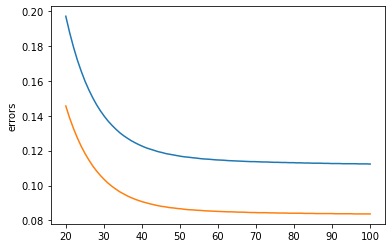

In [9]:
adj_epochs(trainset[:1000])

From the graph, we can know the two error methodss are having the same pattern. And they both reached minimum error point approximatly at 100 iteration. 

    number_epochs = 100

In [10]:
def adj_alpha(trainset):
    steps = np.arange(0, 0.8, 0.01)
    iterationList = []

    for alpha in steps:

        pred_rating = gen_list(trainset, 100, alpha, 0.1)

        error = accuray(pred_rating)
        iterationList.append(error)
        
    plt.plot(np.linspace(0, 0.8, 80), iterationList)
    plt.ylabel('errors')
    plt.show()

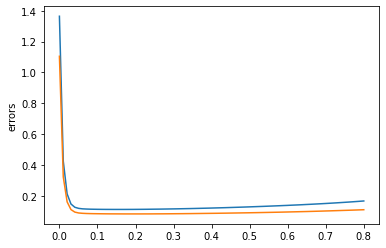

In [11]:
adj_alpha(trainset[:1000])

From the graph we can know, the learning rate has the minimum error at approximate 0.1

    alpha = 0.1

In [12]:
def adj_reg(trainset):
    steps = np.arange(-0.2, 1, 0.01)
    iterationList = []

    for reg in steps:

        pred_rating = gen_list(trainset, 100, 0.1, reg)

        error = accuray(pred_rating)
        iterationList.append(error)
        
    plt.plot(np.linspace(-0.2, 1, 120), iterationList)
    plt.ylabel('errors')
    plt.show()

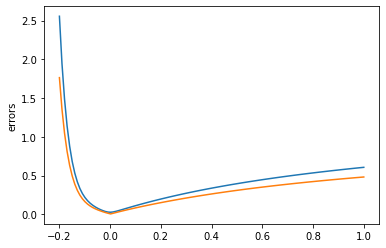

In [13]:
adj_reg(trainset[:1000])

From the graph we can know, the regularizaiton coefficient has the minimum error at approximate 0.0

    reg = 0.0

Train the model using training set

In [14]:
print("Dataset:", dataset.shape)
print("Training set:", trainset.shape)
print("Testing set:", testset.shape)

Dataset: (2023070, 4)
Training set: (800, 4)
Testing set: (6, 4)


In [15]:
start_time = time.time()
bcf = BaselineCFBySGD(trainset, 100, 0.1, 0.0, ["UserId", "ProductId", "Rating"])
elapsed_time = time.time() - start_time
print(elapsed_time)

0.45529842376708984


Addjust perameters:

    _20, 0.1, 0.1 : (0.2061, 0.1527)

    _20, 0.1, 0.0 : (0.1417, 0.0962)

    100, 0.0, 0.0 : (1.3904, 1.1334)

    100, 0.1, 0.0 : (0.0222, 0.0044)

    100, 0.1, 0.1 : (0.1158, 0.0873)

Calculate the training set predict error

In [16]:
pred_rating =[]
for uid, iid, real_rating, _ in trainset.itertuples(index=False):
    pred_rating_result = (uid, iid, real_rating, bcf.predict(uid, iid))
    pred_rating.append(pred_rating_result)

trainError = accuray(pred_rating)
print(trainError)

(0.0257, 0.004)


Calculate the testing set predict error

In [17]:
test_pred_rating =[]
for uid, iid, real_rating, _ in testset.itertuples(index=False):
    pred_rating_result = (uid, iid, real_rating, bcf.predict(uid, iid))
    test_pred_rating.append(pred_rating_result)

testError = accuray(test_pred_rating)
print(testError)

Kicked: '1304651118'
(2.0808, 1.1276)
